## Euler Maruyama

### 1. Running Simulations

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import numba
from numba import njit, objmode

In [3]:
@numba.jit(nopython=True)
def dot_product(v1,v2):
    dot = 0
    for i in range(len(v1)):
    
        dot += v1[i]*v2[i]
        
    return dot

@numba.jit(nopython=True)
def matrix_vec_multiplication(A,x):
    v = np.zeros(len(A))
    
    for i in range(len(A)):
        for j in range(len(x)):
                v[i] += A[i][j] * x[j]
    return v


@numba.jit(nopython=True)
def random_gaussian(n):
    with objmode(y="float64[:]"):
        rng = np.random.default_rng()
        y=rng.standard_normal(n)
    return y

@numba.jit(nopython=True)
def fill_in_array(x0,n):
    X = np.zeros(n)
    for i in range(0,n):
        X[i]=x0
    return X


@numba.jit(nopython=True)
def power2(X):
    n=len(X)
    Xsq=fill_in_array(0,n)
    for i in range(0,n):
        Xsq[i]=X[i]*X[i]
    return Xsq


In [4]:
@numba.jit(nopython=True)
def EM_Step_a(Xold,Vold,dt, gamma, u,DU):
    Vnew=Vold
    n=len(Xold)
    Rn=random_gaussian(n)
    NUXold=DU(Xold)
    Xnew = Xold + Vold* dt
    b = - Vold* gamma -DU(Xold) 
    Vnew=Vold + b * dt + np.sqrt(2*gamma*u) * Rn 
    return Xnew, Vnew

In [5]:
@numba.jit(nopython=True)
def run_simulation_a(x0, v0, gamma, u, step_function, dt,n,DU,T):
    X0=x0
    V0=v0
    Xn=X0
    Vn=V0
    Xmean=fill_in_array(0,int(T/dt+1))
    Xmean[0]=np.mean(X0)
    Xmeansq=fill_in_array(0,int(T/dt+1))
    Xmeansq[0]=np.mean(power2(X0))
    for i in range(1,int(T/dt+1)):
        Xn, Vn =step_function(Xn,Vn,dt, gamma, u,DU)
        Xmean[i]=np.mean(Xn)
        Xsq=power2(Xn)
        Xmeansq[i]=np.mean(Xsq)
        if i==int(0.1/dt):
            X01=Xn
        if i==int(0.4/dt):
            X04=Xn
        if i==int(2/dt):
            X2=Xn
        if i==int(T/dt):
            XT=Xn
            
    return X01,X04,X2,XT,Xmean,Xmeansq

In [6]:
A=[1,2,3]
print(A[0:1])

[1]


In [7]:
@numba.jit(nopython=True)
def cumulative_expectation(X_mean,timesteps):
    U=fill_in_array(0,timesteps)
#     if timesteps > 5000:
#         for i in range(0,1001):
#             U[i]=X_mean[i]
    for j in range(0,timesteps):
        U[j]=np.sum(X_mean[0:j+1])/(j+1)
#             print(U[j])
    
    return U

In [8]:
def plot_results(XT,Xmean,Xmeansq,T,normalized_exact_dist):
    t=np.linspace(0,T,int(T/dt+1))
    Ntimesteps=int(T/dt+1)

    CE=cumulative_expectation(Xmean,Ntimesteps)
    CEsq=cumulative_expectation(Xmeansq,Ntimesteps)
    
    fig = plt.figure(figsize=(5, 5))
    plt.plot(t,Xmean)
    plt.plot(t,CE)
    plt.show()
    print(CE[-1])
    print(Xmean[-1])
    
    fig = plt.figure(figsize=(5, 5))
    plt.plot(t[1:],Xmeansq[1:])
    plt.plot(t[1:],CEsq[1:])
    plt.show()
    print(CEsq[-1])
    print(Xmeansq[-1])
    
    fig = plt.figure(figsize=(10, 10))
    plt.hist(XT, bins=300, alpha=0.5, range=[-6,6], label='gamma',histtype=u'step',density=True)
    plt.plot(x,normalized_exact_dist,label='Exact distribution')
    plt.legend(loc='upper right')
    plt.title('Distribution of X')
    plt.xlabel('x')
    plt.ylabel('scaled frequency')
    plt.show()

### 2. Potential Functions

In [9]:
@numba.jit(nopython=True)
def grad_potential_a1(x_n):
    # calculates \nabla U(x_n)
    return (-x_n+np.power(x_n, 3))

@numba.jit(nopython=True)
def grad_potential_a2(x_n):
    # calculates \nabla U(x_n)
    n=len(x_n)
    du=4*np.power(x_n-fill_in_array(0.9,n),3)/8 - 2*(x_n-fill_in_array(1,n))/1.2
    return (du)

@numba.jit(nopython=True)
def grad_potential_b1(x_n):
    # calculates \nabla U(x_n)
    n=len(x_n)
    dU=fill_in_array(0,n)
    for i in range(0,n):
        a1= -2*np.power(x_n[i]-1,2)
        a2= -2*np.power(x_n[i]+1,2)
        a3=-1*np.power(x_n[i]-3,2)
        a4=-1*np.power(x_n[i]+3,2)
        frac1=4*(x_n[i]-1)*np.exp(a1) + 4*(x_n[i]+1)*np.exp(a2) + 2*(x_n[i]-3)*np.exp(a3)+2*(x_n[i]+3)*np.exp(a4)
        frac2=np.exp(a1)+np.exp(a2)+np.exp(a3)+np.exp(a4)
        dU[i]=frac1/frac2
    return dU

@numba.jit(nopython=True)
def grad_potential_b2(x_n):
    # calculates \nabla U(x_n)
    n=len(x_n)
    dU=fill_in_array(0,n)
    for i in range(0,n):
        a1= -2*np.power(x_n[i]-1,2)
        a2= -3*np.power(x_n[i]+1.1,2)
        a3=-1*np.power(x_n[i]-3,2)
        a4=-1*np.power(x_n[i]+3,2)
        frac1=4*(x_n[i]-1)*np.exp(a1) + 12*(x_n[i]+1.1)*np.exp(a2) + 3*(x_n[i]+3)*np.exp(a4)+2*(x_n[i]-3)*np.exp(a3)
        frac2=np.exp(a1)+2*np.exp(a2)+1.5*np.exp(a4)+np.exp(a3)
        dU[i]=frac1/frac2
    return dU

@numba.jit(nopython=True)
def grad_potential_c(x_n):
    # calculates \nabla U(x_n)
    return (x_n)

### 3. Exact Distributions, find exact values

In [10]:
@numba.jit(nopython=True)
def evaluate_dist_a1(x_n):
    # calculates e^{-U(x_n)}
    U=-0.5*np.power(x_n, 2)+0.25*np.power(x_n,4)
    exact_dist=np.exp(-U)
    norm_dist = exact_dist / np.trapz(exact_dist,x_n)
    return norm_dist

def evaluate_dist_a2(x_n):
    # calculates e^{-U(x_n)}
    n=len(x_n)
    U=-np.power(x_n-fill_in_array(1,n), 2)/1.2+np.power(x_n-fill_in_array(0.9,n),4)/8
    exact_dist=np.exp(-U)
    norm_dist = exact_dist / np.trapz(exact_dist,x_n)
    return norm_dist


@numba.jit(nopython=True)
def evaluate_dist_b1(x_n):
    # calculates U(x_n)
    n=len(x_n)
    exact_dist=fill_in_array(0,n)
    for i in range(0,n):
        a1= -2*np.power(x_n[i]-1,2)
        a2= -2*np.power(x_n[i]+1,2)
        a3=-1*np.power(x_n[i]-3,2)
        a4=-1*np.power(x_n[i]+3,2)
        exact_dist[i]=np.exp(a1)+np.exp(a2)+np.exp(a3)+np.exp(a4)
        
    norm_dist = exact_dist / np.trapz(exact_dist,x_n)
    return norm_dist

@numba.jit(nopython=True)
def evaluate_dist_b2(x_n):
    # calculates U(x_n)
    n=len(x_n)
    exact_dist=fill_in_array(0,n)
    for i in range(0,n):
        a1= -2*np.power(x_n[i]-1,2)
        a2= -3*np.power(x_n[i]+1.1,2)
        a3=-1*np.power(x_n[i]+3,2)
        a4=-1*np.power(x_n[i]-3,2)
        exact_dist[i]=np.exp(a1)+2*np.exp(a2)+1.5*np.exp(a3)+np.exp(a4)
        
    norm_dist = exact_dist / np.trapz(exact_dist,x_n)
    return norm_dist

@numba.jit(nopython=True)
def evaluate_dist_c(x_n):
    # calculates e^{-U(x_n)}
    U=np.power(x_n, 2)
    exact_dist=np.exp(-U)
    norm_dist = exact_dist / np.trapz(exact_dist,x_n)
    return norm_dist

In [11]:
# x=np.linspace(-6,6,10001)
# normalized_exact_dist=evaluate_dist_a1(x)
# plt.plot(x,normalized_exact_dist,label='Exact distribution')
# plt.xlabel('x')
# plt.ylabel('frequency')
# plt.title('Normalized $e^{-U(x)}$ case (a1)')
# print('a1 distribution has expectation of x^2 : 1.041797296487154')
# print('a1 distribution has expectation of u(x) :−0.01044932412178899')

a2 distribution has expectation of x^2 : 2.817515980129208
a2 distribution has expectation of u(x) :−0.9918541927203226


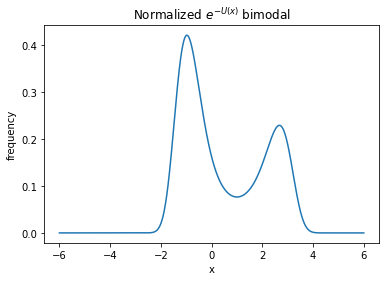

In [12]:
x=np.linspace(-6,6,10001)
normalized_exact_dist=evaluate_dist_a2(x)
plt.plot(x,normalized_exact_dist,label='Exact distribution')
plt.xlabel('x')
plt.ylabel('frequency')
plt.title('Normalized $e^{-U(x)}$ bimodal')
print('a2 distribution has expectation of x^2 : 2.817515980129208')
print('a2 distribution has expectation of u(x) :−0.9918541927203226')

In [13]:
# x=np.linspace(-7,7,10001)
# normalized_exact_dist=evaluate_dist_b1(x)
# plt.xlabel('x')
# plt.ylabel('frequency')
# plt.title('Normalized $e^{-U(x)}$ case (b1)')
# plt.plot(x,normalized_exact_dist,label='Exact distribution')
# print('b1 distribution has expectation of x^2 : 6.082738110421955')

b2 distribution has expectation of x^2 : 6.012076943431412


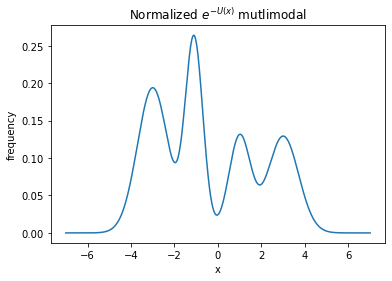

In [14]:
x=np.linspace(-7,7,10001)
normalized_exact_dist=evaluate_dist_b2(x)
plt.xlabel('x')
plt.ylabel('frequency')
plt.title('Normalized $e^{-U(x)}$ mutlimodal')
plt.plot(x,normalized_exact_dist,label='Exact distribution')
print('b2 distribution has expectation of x^2 : 6.012076943431412')

c distribution has expectation of x^2 : 1.0
c distribution has expectation of u(x) : 0.5


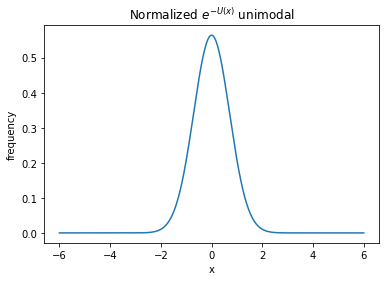

In [15]:
x=np.linspace(-6,6,10001)
normalized_exact_dist=evaluate_dist_c(x)
plt.xlabel('x')
plt.ylabel('frequency')
plt.title('Normalized $e^{-U(x)}$ unimodal')
plt.plot(x,normalized_exact_dist,label='Exact distribution')
print('c distribution has expectation of x^2 : 1.0')
print('c distribution has expectation of u(x) : 0.5')

### 4. Find convergence steps

In [16]:
@numba.jit(nopython=True)
def find_convergence_time(x0, v0, gamma, u, step_function, dt,n,DU,T,epsilon, xsq_true_value,burnin):
    X0=x0
    V0=v0
    Xn=X0
    Vn=V0
    Xmeansq=fill_in_array(0,int(T/dt+1))
    counter=1
    xsquare=0
    CE=np.mean(power2(X0))
    
    #burn in period
    for i in range(0,burnin):
        Xn, Vn =step_function(Xn,Vn,dt, gamma, u,DU)
        Xsq=power2(Xn)
        xsquare=np.mean(Xsq)
        counter=counter+1
        CE=(CE*(counter-1)+xsquare)/counter
    
    while abs(CE-xsq_true_value)>epsilon and counter <=T:
        Xn, Vn =step_function(Xn,Vn,dt, gamma, u,DU)
        Xsq=power2(Xn)
        xsquare=np.mean(Xsq)
        counter=counter+1
        CE=(CE*(counter-1)+xsquare)/counter
        if CE > 100:
            counter=T
#         print(xsquare)
#         print(CE)
    
    converged= False
    if CE < 10:
        converged= True
    
    if converged== False:
        counter=0
        
#     print(CE)
    
    return counter

In [47]:
@numba.jit(nopython=True)
def find_convergence_time_2(x0, v0, gamma, u, step_function, dt,n,DU,T,epsilon, xsq_true_value,burnin):
    X0=x0
    V0=v0
    Xn=X0
    Vn=V0
    Xmeansq=fill_in_array(0,int(T/dt+1))
    counter=1
    xsquare=0
    exact_value=fill_in_array(xsq_true_value,n)
    CXsq=fill_in_array(0,n)
    
    #burn in period
    for i in range(0,burnin):
        Xn, Vn =step_function(Xn,Vn,dt, gamma, u,DU)
        Xsq=power2(Xn)
        counter=counter+1
        
        CXsq=(CXsq*(counter-1)+Xsq)/counter #cumulative X^2 over time for each path
        
        error_n=np.absolute(CXsq - exact_value)
        error=np.mean(error_n)
        
    while abs(error)>epsilon and counter <=T:
        Xn, Vn =step_function(Xn,Vn,dt, gamma, u,DU)
        Xsq=power2(Xn)
        counter=counter+1
        CXsq=(CXsq*(counter-1)+Xsq)/counter #cumulative X^2 over time for each path
        error_n=np.absolute(CXsq - exact_value)
        error=np.mean(error_n)
        if np.mean(CXsq) > 100:
            counter=T
    
    converged= False
    if np.mean(CXsq) < 10:
        converged= True
    
    if converged== False:
        counter=0
        
#     print(CE)
#     print(error)
    return counter

### CONVERGENCE FOR A2

In [40]:
gammas_set=np.logspace(-3,1.699,50)
gammas_set

array([1.00000000e-03, 1.24709047e-03, 1.55523463e-03, 1.93951828e-03,
       2.41875476e-03, 3.01640600e-03, 3.76173116e-03, 4.69121907e-03,
       5.85037458e-03, 7.29594636e-03, 9.09870515e-03, 1.13469085e-02,
       1.41506214e-02, 1.76471050e-02, 2.20075364e-02, 2.74453888e-02,
       3.42268827e-02, 4.26840192e-02, 5.32308334e-02, 6.63836648e-02,
       8.27864355e-02, 1.03242174e-01, 1.28752331e-01, 1.60565805e-01,
       2.00240085e-01, 2.49717501e-01, 3.11420314e-01, 3.88369305e-01,
       4.84331658e-01, 6.04005393e-01, 7.53249367e-01, 9.39370105e-01,
       1.17147950e+00, 1.46094092e+00, 1.82192549e+00, 2.27210591e+00,
       2.83352162e+00, 3.53365780e+00, 4.40679095e+00, 5.49566698e+00,
       6.85359390e+00, 8.54705161e+00, 1.06589466e+01, 1.32926707e+01,
       1.65771629e+01, 2.06732218e+01, 2.57813778e+01, 3.21517104e+01,
       4.00960915e+01, 5.00034535e+01])

In [48]:
xsq_true_value=2.817515980129208
u = 0.01
T=1000000
epsilon=0.1
dt=0.01 # step size
n=100 # number of paths
x0 = 1*random_gaussian(n)
v0 = 1*random_gaussian(n)

number_of_steps_a2=np.zeros(50)
c=0

for gamma in gammas_set:
    print(f'gamma is {gamma}')
    steps_for_gamma_a2=np.zeros(10)
    
    start_time = time.time()
    for i in range(0,10):
        conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_a2,T,epsilon,xsq_true_value,20000)
        steps_for_gamma_a2[i]=conv_steps
        
    if np.all(steps_for_gamma_a2):
        number_of_steps_a2[c]=np.mean(steps_for_gamma_a2)
    else:
        number_of_steps_a2[c]=0
        
    print(f'time needed for python to run {time.time()-start_time}')
    print(f'steps to reach convergence {number_of_steps_a2[c]}')
    c=c+1
    

print(number_of_steps_a2)

gamma is 0.001
time needed for python to run 11.75700569152832
steps to reach convergence 0.0
gamma is 0.0012470904663564033
time needed for python to run 11.165578126907349
steps to reach convergence 0.0
gamma is 0.0015552346312770332
time needed for python to run 11.162246227264404
steps to reach convergence 0.0
gamma is 0.0019395182816129045
time needed for python to run 11.084485530853271
steps to reach convergence 0.0
gamma is 0.0024187547583234097
time needed for python to run 11.188671350479126
steps to reach convergence 0.0
gamma is 0.0030164059995593105
time needed for python to run 11.200044870376587
steps to reach convergence 0.0
gamma is 0.003761731164710674
time needed for python to run 11.217443943023682
steps to reach convergence 0.0
gamma is 0.004691219072506456
time needed for python to run 11.184062957763672
steps to reach convergence 0.0
gamma is 0.0058503745809121354
time needed for python to run 11.260817527770996
steps to reach convergence 0.0
gamma is 0.007295946

KeyboardInterrupt: 

In [50]:
number_of_steps_a2=[      0,        0,        0,        0,        0,        0,        0,
       0,        0,        0,        0,        0,        0,        0,
       0,        0,        0,        0,        0,        0,        0,
 1000001,  1000001,  1000001,  1000001,  1000001,   907156.4,  807997.1,
  772744.4,  781896.8,  744765.6,  751273.5,  799349.6,  849991.4,  978600.6,
  995124.8, 1000001,  1000001,  1000001,        1000001,       1000001,        1000001,
    1000001,   1000001,   1000001,      1000001,      1000001,    1000001,      1000001,
      1000001 ]


In [51]:
print(number_of_steps_a2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000001, 1000001, 1000001, 1000001, 1000001, 907156.4, 807997.1, 772744.4, 781896.8, 744765.6, 751273.5, 799349.6, 849991.4, 978600.6, 995124.8, 1000001, 1000001, 1000001, 1000001, 1000001, 1000001, 1000001, 1000001, 1000001, 1000001, 1000001, 1000001, 1000001, 1000001]


Text(0.5, 1.0, 'Number of steps to reach convergence for Euler Maruyama (bimodal)')

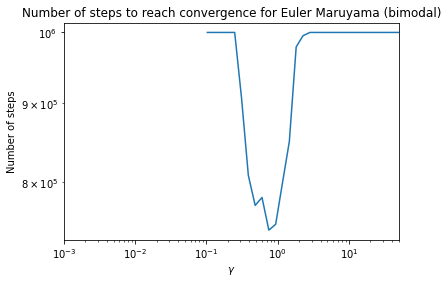

In [55]:
plt.loglog(gammas_set[21:],number_of_steps_a2[21:])
plt.xlim([10**(-3), 50])
plt.xlabel('$\gamma$')
plt.ylabel('Number of steps')
plt.title('Number of steps to reach convergence for Euler Maruyama (bimodal)')

Text(0.5, 1.0, 'Number of steps to reach convergence for Euler Maruyama')

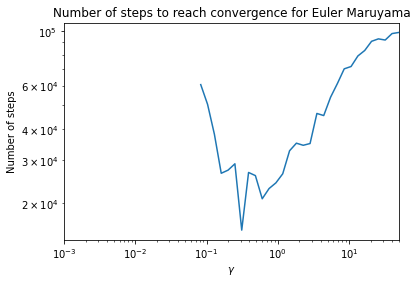

In [17]:
plt.loglog(gammas_set[20:],number_of_steps[20:])
plt.xlim([10**(-3), 50])
plt.xlabel('$\gamma$')
plt.ylabel('Number of steps')
plt.title('Number of steps to reach convergence for Euler Maruyama')

### CONVERGENCE FOR B2:

Counting number of steps to get close to the expectation of $X^2$

In [56]:
gammas_set=np.logspace(-3,1.699,50)
gammas_set

array([1.00000000e-03, 1.24709047e-03, 1.55523463e-03, 1.93951828e-03,
       2.41875476e-03, 3.01640600e-03, 3.76173116e-03, 4.69121907e-03,
       5.85037458e-03, 7.29594636e-03, 9.09870515e-03, 1.13469085e-02,
       1.41506214e-02, 1.76471050e-02, 2.20075364e-02, 2.74453888e-02,
       3.42268827e-02, 4.26840192e-02, 5.32308334e-02, 6.63836648e-02,
       8.27864355e-02, 1.03242174e-01, 1.28752331e-01, 1.60565805e-01,
       2.00240085e-01, 2.49717501e-01, 3.11420314e-01, 3.88369305e-01,
       4.84331658e-01, 6.04005393e-01, 7.53249367e-01, 9.39370105e-01,
       1.17147950e+00, 1.46094092e+00, 1.82192549e+00, 2.27210591e+00,
       2.83352162e+00, 3.53365780e+00, 4.40679095e+00, 5.49566698e+00,
       6.85359390e+00, 8.54705161e+00, 1.06589466e+01, 1.32926707e+01,
       1.65771629e+01, 2.06732218e+01, 2.57813778e+01, 3.21517104e+01,
       4.00960915e+01, 5.00034535e+01])

In [75]:
number_of_steps_b2=np.zeros(50)

In [57]:
xsq_true_value=6.012076943431412
u = 0.01
T=1000000
epsilon=0.1
dt=0.01 # step size
n=100 # number of paths
x0 = 1*random_gaussian(n)
v0 = 1*random_gaussian(n)

In [58]:
gamma=gammas_set[0]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

ZeroDivisionError: division by zero

In [59]:
gamma=gammas_set[1]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

ZeroDivisionError: division by zero

In [60]:
gamma=gammas_set[2]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

ZeroDivisionError: division by zero

In [61]:
gamma=gammas_set[3]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

ZeroDivisionError: division by zero

In [62]:
gamma=gammas_set[4]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

ZeroDivisionError: division by zero

In [63]:
gamma=gammas_set[5]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

ZeroDivisionError: division by zero

In [65]:
gamma=gammas_set[6]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

ZeroDivisionError: division by zero

In [66]:
gamma=gammas_set[7]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

ZeroDivisionError: division by zero

In [67]:
gamma=gammas_set[8]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

ZeroDivisionError: division by zero

In [68]:
gamma=gammas_set[9]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

ZeroDivisionError: division by zero

In [69]:
gamma=gammas_set[10]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

ZeroDivisionError: division by zero

In [70]:
gamma=gammas_set[11]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

ZeroDivisionError: division by zero

In [72]:
gamma=gammas_set[12]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

gamma is 0.014150621355555537
time needed for python to run 40.18273067474365
steps to reach convergence 1000001


In [71]:
gamma=gammas_set[13]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

gamma is 0.017647104985532645
time needed for python to run 42.03975248336792
steps to reach convergence 1000001


In [73]:
gamma=gammas_set[14]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

gamma is 0.022007536386248326
time needed for python to run 40.99228477478027
steps to reach convergence 1000001


In [74]:
gamma=gammas_set[15]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

gamma is 0.027445388815281958
time needed for python to run 40.53817367553711
steps to reach convergence 1000001


In [77]:
gamma=gammas_set[-1]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

gamma is 50.003453497697855
time needed for python to run 42.04915761947632
steps to reach convergence 1000001


In [78]:
gamma=gammas_set[-6]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

gamma is 16.577162857056795
time needed for python to run 41.096999406814575
steps to reach convergence 1000001


In [79]:
gamma=gammas_set[-8]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

gamma is 10.658946581870383
time needed for python to run 44.69834518432617
steps to reach convergence 1000001


In [80]:
gamma=gammas_set[-10]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

gamma is 6.853593899923722
time needed for python to run 40.82207894325256
steps to reach convergence 1000001


In [81]:
gamma=gammas_set[-12]
start_time = time.time()
conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
print(f'gamma is {gamma}')
print(f'time needed for python to run {time.time()-start_time}')
print(f'steps to reach convergence {conv_steps}')

gamma is 4.406790951083763
time needed for python to run 40.307066440582275
steps to reach convergence 1000001


In [76]:
number_of_steps_b2[12]=1000001
number_of_steps_b2[13]=1000001
number_of_steps_b2[14]=1000001
number_of_steps_b2[15]=1000001

In [82]:
xsq_true_value=6.012076943431412
u = 0.01
T=1000000
epsilon=0.1
dt=0.01 # step size
n=100 # number of paths
x0 = 1*random_gaussian(n)
v0 = 1*random_gaussian(n)

c=16

for gamma in gammas_set[16:-12]:
    print(f'gamma is {gamma}')
    steps_for_gamma_b2=np.zeros(10)
    
    start_time = time.time()
    for i in range(0,10):
        conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_b2,T,epsilon,xsq_true_value,20000)
        steps_for_gamma_b2[i]=conv_steps
        
    if np.all(steps_for_gamma_b2):
        number_of_steps_b2[c]=np.mean(steps_for_gamma_b2)
    else:
        number_of_steps_b2[c]=0
        
    print(f'time needed for python to run {time.time()-start_time}')
    print(f'steps to reach convergence {number_of_steps_b2[c]}')
    c=c+1
    

print(number_of_steps_b2)


gamma is 0.03422688273698281
time needed for python to run 381.84716272354126
steps to reach convergence 1000001.0
gamma is 0.042684019154389845
time needed for python to run 352.2239534854889
steps to reach convergence 1000001.0
gamma is 0.05323083335321371
time needed for python to run 350.99919509887695
steps to reach convergence 1000001.0
gamma is 0.06638366479099932
time needed for python to run 351.79773783683777
steps to reach convergence 1000001.0
gamma is 0.08278643548265453
time needed for python to run 350.9018511772156
steps to reach convergence 1000001.0
gamma is 0.10324217443404794
time needed for python to run 351.6820001602173
steps to reach convergence 1000001.0
gamma is 0.12875233146260612
time needed for python to run 351.12478399276733
steps to reach convergence 1000001.0
gamma is 0.1605658050881757
time needed for python to run 351.7893497943878
steps to reach convergence 1000001.0
gamma is 0.2002400847483044
time needed for python to run 351.3603777885437
steps to

In [83]:
number_of_steps_b2

array([      0. ,       0. ,       0. ,       0. ,       0. ,       0. ,
             0. ,       0. ,       0. ,       0. ,       0. ,       0. ,
       1000001. , 1000001. , 1000001. , 1000001. , 1000001. , 1000001. ,
       1000001. , 1000001. , 1000001. , 1000001. , 1000001. , 1000001. ,
       1000001. , 1000001. , 1000001. , 1000001. ,  967356.8,  952689.2,
        952947.5,  816301.8,  902163.9,  983770.7,  998603.3,  988830.3,
       1000001. , 1000001. ,       0. ,       0. ,       0. ,       0. ,
             0. ,       0. ,       0. ,       0. ,       0. ,       0. ,
             0. ,       0. ])

In [89]:
number_of_steps_b2=[      0 ,       0 ,       0 ,       0 ,       0 ,       0 ,
             0 ,       0 ,       0 ,       0 ,       0 ,       0 ,
       1000001 , 1000001 , 1000001 , 1000001 , 1000001 , 1000001 ,
       1000001 , 1000001 , 1000001 , 1000001 , 1000001 , 1000001 ,
       1000001 , 1000001 , 1000001 , 1000001 ,  967356.8,  952689.2,
        952947.5,  816301.8,  902163.9,  983770.7,  998603.3,  988830.3,
       1000001 , 1000001 ,       1000001 ,       1000001,        1000001,       1000001 ,
             1000001 ,       1000001 ,       1000001 ,       1000001 ,       1000001 ,       1000001 ,
             1000001 ,       1000001 ]


Text(0.5, 1.0, 'Number of steps to reach convergence for Euler Maruyama (4-modal)')

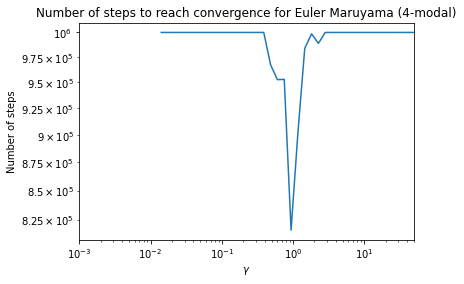

In [90]:
plt.loglog(gammas_set[12:],number_of_steps_b2[12:])
plt.xlim([10**(-3), 50])
plt.xlabel('$\gamma$')
plt.ylabel('Number of steps')
plt.title('Number of steps to reach convergence for Euler Maruyama (4-modal)')

Text(0.5, 1.0, 'Number of steps to reach convergence for Euler Maruyama')

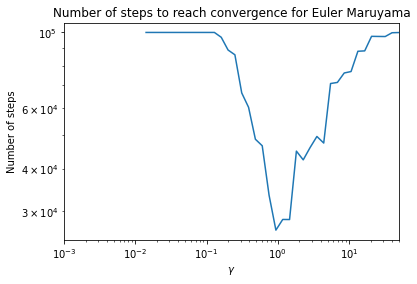

In [27]:
plt.loglog(gammas_set[12:],number_of_steps_b2[12:])
plt.xlim([10**(-3), 50])
plt.xlabel('$\gamma$')
plt.ylabel('Number of steps')
plt.title('Number of steps to reach convergence for Euler Maruyama')

### CONVERGENCE FOR C:

In [85]:
gammas_set=np.logspace(-3,1.699,50)
gammas_set

array([1.00000000e-03, 1.24709047e-03, 1.55523463e-03, 1.93951828e-03,
       2.41875476e-03, 3.01640600e-03, 3.76173116e-03, 4.69121907e-03,
       5.85037458e-03, 7.29594636e-03, 9.09870515e-03, 1.13469085e-02,
       1.41506214e-02, 1.76471050e-02, 2.20075364e-02, 2.74453888e-02,
       3.42268827e-02, 4.26840192e-02, 5.32308334e-02, 6.63836648e-02,
       8.27864355e-02, 1.03242174e-01, 1.28752331e-01, 1.60565805e-01,
       2.00240085e-01, 2.49717501e-01, 3.11420314e-01, 3.88369305e-01,
       4.84331658e-01, 6.04005393e-01, 7.53249367e-01, 9.39370105e-01,
       1.17147950e+00, 1.46094092e+00, 1.82192549e+00, 2.27210591e+00,
       2.83352162e+00, 3.53365780e+00, 4.40679095e+00, 5.49566698e+00,
       6.85359390e+00, 8.54705161e+00, 1.06589466e+01, 1.32926707e+01,
       1.65771629e+01, 2.06732218e+01, 2.57813778e+01, 3.21517104e+01,
       4.00960915e+01, 5.00034535e+01])

In [86]:
xsq_true_value=1
u = 0.01
T=1000000
epsilon=0.1
dt=0.01 # step size
n=100 # number of paths
x0 = 1*random_gaussian(n)
v0 = 1*random_gaussian(n)

number_of_steps_c=np.zeros(50)
c=10

for gamma in gammas_set[12:-12]:
    print(f'gamma is {gamma}')
    steps_for_gamma_c=np.zeros(10)
    
    start_time = time.time()
    for i in range(0,10):
        conv_steps=find_convergence_time_2(x0, v0, gamma, u, EM_Step_a, dt,n,grad_potential_c,T,epsilon,xsq_true_value,20000)
        steps_for_gamma_c[i]=conv_steps
        
    if np.all(steps_for_gamma_b2):
        number_of_steps_c[c]=np.mean(steps_for_gamma_b2)
    else:
        number_of_steps_c[c]=0
        
    print(f'time needed for python to run {time.time()-start_time}')
    print(f'steps to reach convergence {number_of_steps_c[c]}')
    c=c+1
    

print(number_of_steps_c)

gamma is 0.014150621355555537
time needed for python to run 301.58103132247925
steps to reach convergence 1000001.0
gamma is 0.017647104985532645
time needed for python to run 300.97331833839417
steps to reach convergence 1000001.0
gamma is 0.022007536386248326
time needed for python to run 299.7185935974121
steps to reach convergence 1000001.0
gamma is 0.027445388815281958
time needed for python to run 300.9782168865204
steps to reach convergence 1000001.0
gamma is 0.03422688273698281
time needed for python to run 300.6495110988617
steps to reach convergence 1000001.0
gamma is 0.042684019154389845
time needed for python to run 300.63378143310547
steps to reach convergence 1000001.0
gamma is 0.05323083335321371
time needed for python to run 299.2907905578613
steps to reach convergence 1000001.0
gamma is 0.06638366479099932
time needed for python to run 301.0861761569977
steps to reach convergence 1000001.0
gamma is 0.08278643548265453
time needed for python to run 300.3303208351135
ste

c distribution has expectation of x^2 : 1.0
c distribution has expectation of u(x) : 0.5


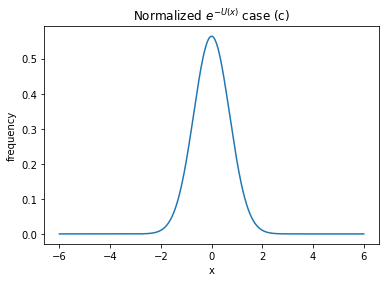

In [16]:
x=np.linspace(-6,6,10001)
normalized_exact_dist=evaluate_dist_c(x)
plt.xlabel('x')
plt.ylabel('frequency')
plt.title('Normalized $e^{-U(x)}$ case (c)')
plt.plot(x,normalized_exact_dist,label='Exact distribution')
print('c distribution has expectation of x^2 : 1.0')
print('c distribution has expectation of u(x) : 0.5')

Text(0.5, 1.0, 'Number of steps to reach convergence for Euler Maruyama')

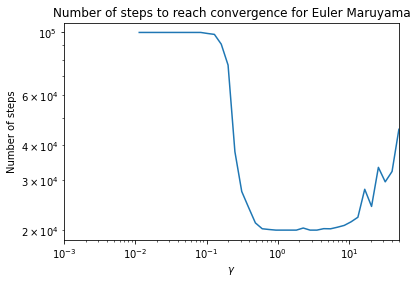

In [24]:
plt.loglog(gammas_set[11:],number_of_steps_c[11:])
plt.xlim([10**(-3), 50])
plt.xlabel('$\gamma$')
plt.ylabel('Number of steps')
plt.title('Number of steps to reach convergence for Euler Maruyama')